# Computing features to train a MLP
This notebook will guide you through the use of the `keras` package to train a multilayer perceptron for handwritten digits classification. You are going to computing the histogram of gradients from the images in the `mnist` dataset (LeCun et al. 1998)

In [13]:
!pip install scikit-image

## Loading the packages

In [14]:
import numpy as np
from matplotlib import pyplot as pl

import tensorflow as tf
from skimage.feature import hog
from skimage import data, color, exposure

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from sklearn import metrics as me
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

Load the `mnist` dataset and normalize in the range [0, 1]

In [15]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Split the training set into a training set and a validation set
X_val = X_train[0:10000,:,:]
X_train = X_train[10000:,:,:]
y_val = y_train[0:10000]
y_train = y_train[10000:]

n_train, height, width = X_train.shape
n_val, _, _ = X_val.shape
n_test, _, _ = X_test.shape

X_train = X_train.reshape(n_train, height, width, 1).astype('float32')
X_val = X_val.reshape(n_val, height, width, 1).astype('float32')
X_test = X_test.reshape(n_test, height, width, 1).astype('float32')

X_train /= 255.0
X_val /= 255.0
X_test /= 255.0

n_classes = 10

print(n_train, 'train samples')
print(n_val, 'validation samples')
print(n_test, 'test samples')

# convert class vectors to binary class matrices
Y_train = tf.keras.utils.to_categorical(y_train, n_classes)
Y_val = tf.keras.utils.to_categorical(y_val, n_classes)
Y_test = tf.keras.utils.to_categorical(y_test, n_classes)

50000 train samples
10000 validation samples
10000 test samples


### An example of how to compute the histogram of gradients
Let's compute the HOG for one image in the test dataset

In [16]:
n_orientations = 8
pix_p_cell = 4
hog_size = int(height * width * n_orientations / (pix_p_cell * pix_p_cell))

In [17]:
fd, hog_image = hog(X_test[0,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualize=True)
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))

Show the image and the corresponding gradients

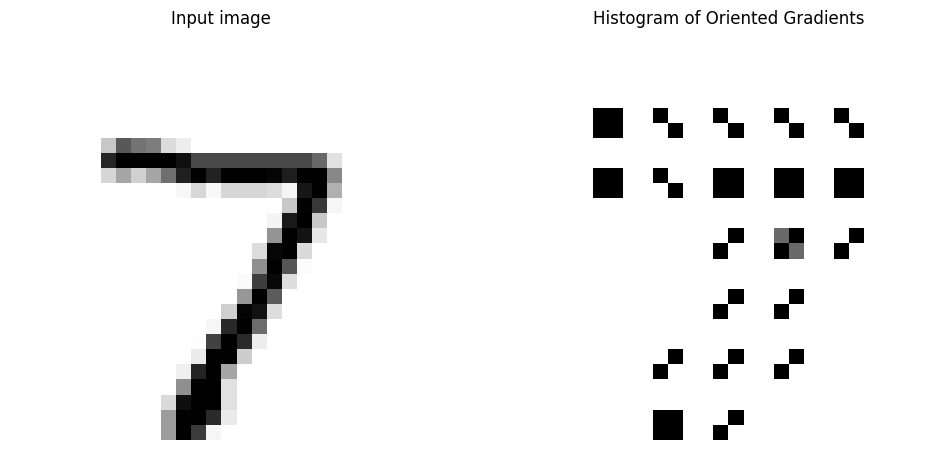

In [18]:
fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(X_test[0,:,:,0], cmap=pl.get_cmap('Greys'), interpolation='nearest')
ax1.set_title('Input image')
ax1.set_adjustable('box')

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=pl.get_cmap('Greys'), interpolation='nearest')
ax2.set_title('Histogram of Oriented Gradients')
ax1.set_adjustable('box')

Compute the HOGs for the train, the validation and the test datasets



In [19]:
X_train_hog = np.zeros((X_train.shape[0], hog_size))
X_val_hog = np.zeros((X_val.shape[0], hog_size))
X_test_hog = np.zeros((X_test.shape[0], hog_size))

for i in np.arange(X_train_hog.shape[0]):
    X_train_hog[i,:] = hog(X_train[i,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualize=False)
print('X_train done')

for i in np.arange(X_val_hog.shape[0]):
    X_val_hog[i,:] = hog(X_val[i,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualize=False)
print('X_val done')

for i in np.arange(X_test_hog.shape[0]):
    X_test_hog[i,:] = hog(X_test[i,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualize=False)
print('X_test done')

X_train done
X_val done
X_test done


Create the MLP

In [20]:
model = Sequential()
model.add(Dense(128, input_shape=(hog_size,), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               50304     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 51594 (201.54 KB)
Trainable params: 51594 (201.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Define some constants and train the MLP. In order to perform the model selection process, you train each model with the train dataset and evaluate it with the validation dataset. The test set remains unseen.

In [21]:
batch_size = 128
n_epoch = 8

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])
history = model.fit(X_train_hog, Y_train,
                    batch_size=batch_size, epochs=n_epoch,
                    verbose=1, validation_data=(X_val_hog, Y_val))

Epoch 1/8
 18/391 [>.............................] - ETA: 2s - loss: 1.7965 - accuracy: 0.4570

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


391/391 [==============================] - 3s 6ms/step - loss: 0.4173 - accuracy: 0.8863 - val_loss: 0.1303 - val_accuracy: 0.9615
Epoch 2/8
391/391 [==============================] - 2s 6ms/step - loss: 0.1569 - accuracy: 0.9515 - val_loss: 0.1068 - val_accuracy: 0.9662
Epoch 3/8
391/391 [==============================] - 2s 6ms/step - loss: 0.1280 - accuracy: 0.9606 - val_loss: 0.0989 - val_accuracy: 0.9669
Epoch 4/8
391/391 [==============================] - 2s 6ms/step - loss: 0.1154 - accuracy: 0.9647 - val_loss: 0.0911 - val_accuracy: 0.9707
Epoch 5/8
391/391 [==============================] - 2s 6ms/step - loss: 0.1040 - accuracy: 0.9677 - val_loss: 0.0877 - val_accuracy: 0.9721
Epoch 6/8
391/391 [==============================] - 2s 6ms/step - loss: 0.0962 - accuracy: 0.9693 - val_loss: 0.0861 - val_accuracy: 0.9728
Epoch 7/8
391/391 [==============================] - 2s 6ms/step - loss: 0.0917 - accuracy: 0.9712 - val_loss: 0.0860 - val_accuracy: 0.9736
Epoch 8/8
391/391 [====

Show the performance of the model. By observing the performance of your models on the validation set, you will choose a set of hyperparameters for your final model. The test set is still not used at this point.

Validation score: 0.08448199927806854
Validation accuracy: 0.9739999771118164


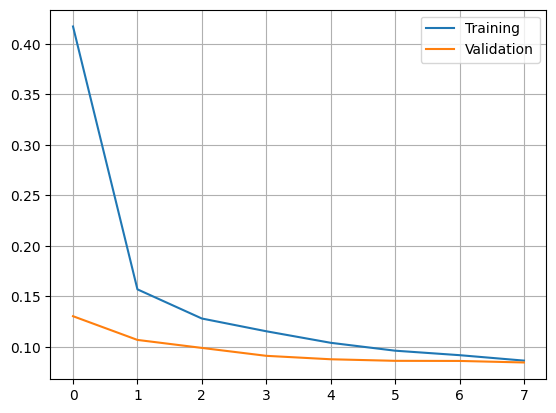

In [22]:
pl.plot(history.history['loss'], label='Training')
pl.plot(history.history['val_loss'], label='Validation')
pl.legend()
pl.grid()

score = model.evaluate(X_val_hog, Y_val, verbose=0)
print('Validation score:', score[0])
print('Validation accuracy:', score[1])

Now that you have chosen your final model, you can finally evaluate its performance using the test set. It is important that the test set remains hidden for your model until this last step in order to have an unbiased estimate of the performance. Therefore, you should not run the following cell until you have chosen your final model.

In [23]:
final_score = model.evaluate(X_test_hog, Y_test, verbose=0)
print('FINAL RESULTS:')
print('Test score:', final_score[0])
print('Test accuracy:', final_score[1])

FINAL RESULTS:
Test score: 0.06717927008867264
Test accuracy: 0.9781000018119812


Confusion matrix

313/313 [==============================] - 1s 2ms/step


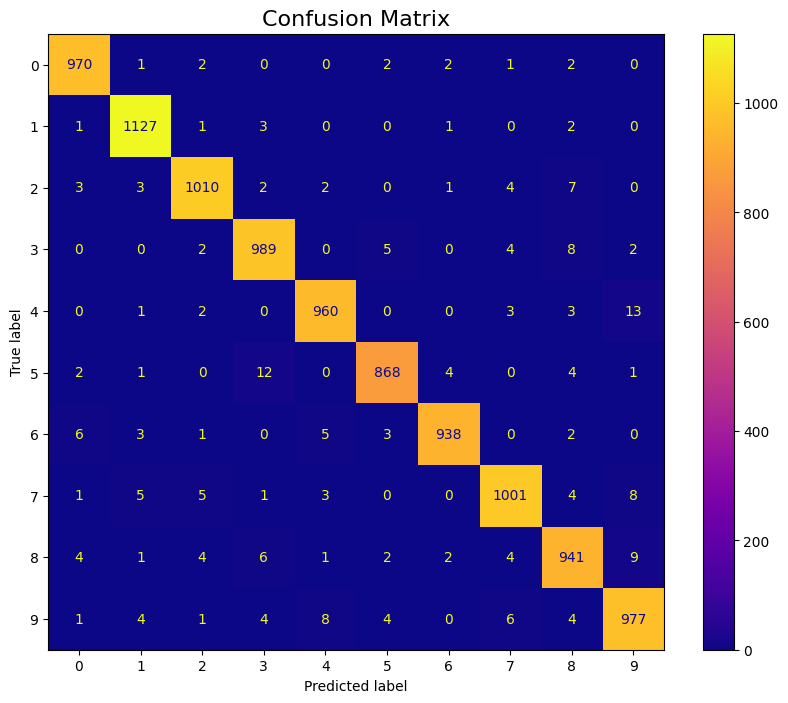

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

pred = model.predict(X_test_hog)
pred = np.argmax(pred, axis=-1)
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = pl.subplots(figsize=(10, 8))
disp.plot(cmap='plasma', ax=ax, values_format='d')
pl.title("Confusion Matrix", fontsize=16)
pl.show()
